# Learning CNN Image Classification(Cats and Dogs) Using Pytorch

## Download dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
path = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
    #     # print(os.path.join(dirname, filename))
    #     pass
    path = os.path.join(dirname)
    print(path)

/kaggle/input
/kaggle/input/cats-and-dogs-40
/kaggle/input/cats-and-dogs-40/catsAndDogs40
/kaggle/input/cats-and-dogs-40/catsAndDogs40/test
/kaggle/input/cats-and-dogs-40/catsAndDogs40/test/dog
/kaggle/input/cats-and-dogs-40/catsAndDogs40/test/cat
/kaggle/input/cats-and-dogs-40/catsAndDogs40/train
/kaggle/input/cats-and-dogs-40/catsAndDogs40/train/dog
/kaggle/input/cats-and-dogs-40/catsAndDogs40/train/cat


## Define the path for train and test data

In [2]:
path_train = "/kaggle/input/cats-and-dogs-40/catsAndDogs40/train"
path_test = "/kaggle/input/cats-and-dogs-40/catsAndDogs40/test"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing torch and setup

In [3]:
import torch            
import torchvision
import torchvision.transforms as transforms

# Define device (CPU or GPU)                         
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(DEVICE)

cpu


## Define data transformations

In [4]:
mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((124, 124)),    
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((124, 124)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(124, 124), interpolation=bilinear, max_size=None, antialias=True)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=path_train, transform=train_transform)
test_dataset = ImageFolder(root=path_test, transform=test_transform)

print(train_dataset)         
print(f'data classes are: {train_dataset.classes}')
print(test_dataset)         
print(f'data classes are: {test_dataset.classes}')

Dataset ImageFolder
    Number of datapoints: 64
    Root location: /kaggle/input/cats-and-dogs-40/catsAndDogs40/train
    StandardTransform
Transform: Compose(
               Resize(size=(124, 124), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
data classes are: ['cat', 'dog']
Dataset ImageFolder
    Number of datapoints: 16
    Root location: /kaggle/input/cats-and-dogs-40/catsAndDogs40/test
    StandardTransform
Transform: Compose(
               Resize(size=(124, 124), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
data classes are: ['cat', 'dog']


### visualization of transformation

In [6]:
def disp_img_grid(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=2)
    plt.figure(figsize=(10, 10),dpi=60)
    # Use permute instead of calling the tensor
    plt.imshow(np.transpose(grid.permute(1, 2, 0).numpy(), (1, 0, 2)))
    # plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f'labels: {lbl}')

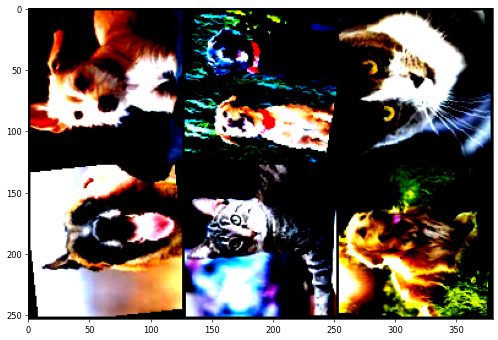

labels: tensor([1, 1, 1, 0, 0, 1])


In [7]:
disp_img_grid(train_dataset)

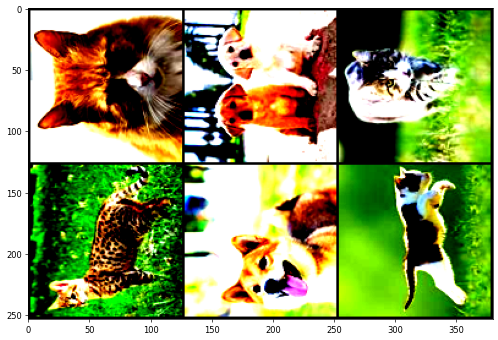

labels: tensor([0, 0, 1, 1, 0, 0])


In [8]:
disp_img_grid(test_dataset)

## Data loader

In [9]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_loader

## Use Readymade CNN Model(ResNet) and modify it

In [10]:
# Load pre-trained ResNet18 model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# rsnt18_model = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
rsnt18_model = models.resnet18(weights = None) # pretrained = False)

# modifying the last layer
last_layer_in = rsnt18_model.fc.in_features
no_of_classes = len(train_dataset.classes)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")
rsnt18_model.fc = nn.Linear(last_layer_in, no_of_classes)

last layer output for model = 512 -> convert to 2 output


In [11]:
# Function to print input and output nodes for each layer
def print_layer_info(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            print(f"Layer: {layer.__class__.__name__}, Input nodes: {layer.in_features}, Output nodes: {layer.out_features}")
        elif isinstance(layer, nn.Conv2d):
            print(f"Layer: {layer.__class__.__name__}, Input channels: {layer.in_channels}, Output channels: {layer.out_channels}")
        elif isinstance(layer, nn.BatchNorm2d):
            print(f"Layer: {layer.__class__.__name__}, Input channels: {layer.num_features}")
        else:
            print(f"Layer: {layer.__class__.__name__}")

# Print the layer information
print_layer_info(rsnt18_model)

Layer: Conv2d, Input channels: 3, Output channels: 64
Layer: BatchNorm2d, Input channels: 64
Layer: ReLU
Layer: MaxPool2d
Layer: Sequential
Layer: Sequential
Layer: Sequential
Layer: Sequential
Layer: AdaptiveAvgPool2d
Layer: Linear, Input nodes: 512, Output nodes: 2


In [12]:
# Move model to device            
rsnt18_model = rsnt18_model.to(DEVICE)          
rsnt18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
loss_fn = nn.CrossEntropyLoss() # criterion = torch.nn.CrossEntropyLoss()
print(loss_fn)
optimizer = optim.SGD(rsnt18_model.parameters(), lr=0.001)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## Training part

In [14]:
def train_NN(model, train_loader, test_loader, loss_citr, optim, n_epochs=10):
    for epoch in range(n_epochs):  
        print(f'epoch number--- {epoch}')
        model.train()
        running_loss=0.0
        running_correct=0
        total=0
        
        for data in train_loader:
            images,labels = data
            images=images.to(DEVICE)
            labels=labels.to(DEVICE)
            total+=labels.size(0)

            optim.zero_grad()
            output=model(images)
            _,predicted=torch.max(output.data,1)
            loss=loss_citr(output,labels)
            loss.backward()
            optim.step()

            running_loss+=loss.item()
            running_correct+= (labels==predicted).sum().item()

        epoch_loss=running_loss/len(train_loader)
        epoch_accuracy=100.0 * running_correct / total
        print(f'   -Training...got {running_correct} out of {total} correctly {epoch_accuracy}, Epoch loss:{epoch_loss}')  
        eval_model_on_test(model,test_loader)
    print("Finished.....")


def eval_model_on_test(model,test_loader):
    model.eval()
    pred_correctly=0
    total=0

    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images=images.to(DEVICE)
            labels=labels.to(DEVICE)
            total+=labels.size(0)

            output=model(images)
            _,predicted=torch.max(output.data,1)

            pred_correctly+=(predicted==labels).sum().item()
    epoch_accuracy=100.0 * pred_correctly / total
    print(f'   -Testing... got {pred_correctly} out of {total} correctly accuracy=({epoch_accuracy}%)')  

In [19]:
train_NN(rsnt18_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=20)


epoch number--- 0
   -Training...got 47 out of 64 correctly 73.4375, Epoch loss:0.6458107829093933
   -Testing... got 9 out of 16 correctly accuracy=(56.25%)
epoch number--- 1
   -Training...got 45 out of 64 correctly 70.3125, Epoch loss:0.6565502285957336
   -Testing... got 8 out of 16 correctly accuracy=(50.0%)
epoch number--- 2
   -Training...got 39 out of 64 correctly 60.9375, Epoch loss:0.6629144549369812
   -Testing... got 8 out of 16 correctly accuracy=(50.0%)
epoch number--- 3
   -Training...got 43 out of 64 correctly 67.1875, Epoch loss:0.6668824255466461
   -Testing... got 8 out of 16 correctly accuracy=(50.0%)
epoch number--- 4
   -Training...got 48 out of 64 correctly 75.0, Epoch loss:0.6453949809074402
   -Testing... got 7 out of 16 correctly accuracy=(43.75%)
epoch number--- 5
   -Training...got 47 out of 64 correctly 73.4375, Epoch loss:0.6393086016178131
   -Testing... got 6 out of 16 correctly accuracy=(37.5%)
epoch number--- 6
   -Training...got 40 out of 64 correctly

### Do cheating .. use `pretrained=true`

In [20]:
rsnt18_model2 = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
# rsnt18_model = models.resnet18(weights = None) # pretrained = False)

# modifying the last layer
last_layer_in = rsnt18_model2.fc.in_features
no_of_classes = len(train_dataset.classes)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")
rsnt18_model2.fc = nn.Linear(last_layer_in, no_of_classes)
rsnt18_model2 = rsnt18_model2.to(DEVICE)          
# rsnt18_model
loss_fn = nn.CrossEntropyLoss() # criterion = torch.nn.CrossEntropyLoss()
# print(loss_fn)
optimizer = optim.SGD(rsnt18_model2.parameters(), lr=0.001)
# print(optimizer)


train_NN(rsnt18_model2, train_loader, test_loader, loss_fn, optimizer, n_epochs=20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


last layer output for model = 512 -> convert to 2 output
epoch number--- 0
   -Training...got 33 out of 64 correctly 51.5625, Epoch loss:0.6921549737453461
   -Testing... got 7 out of 16 correctly accuracy=(43.75%)
epoch number--- 1
   -Training...got 36 out of 64 correctly 56.25, Epoch loss:0.7106130421161652
   -Testing... got 11 out of 16 correctly accuracy=(68.75%)
epoch number--- 2
   -Training...got 42 out of 64 correctly 65.625, Epoch loss:0.5717552006244659
   -Testing... got 13 out of 16 correctly accuracy=(81.25%)
epoch number--- 3
   -Training...got 43 out of 64 correctly 67.1875, Epoch loss:0.5352143347263336
   -Testing... got 13 out of 16 correctly accuracy=(81.25%)
epoch number--- 4
   -Training...got 49 out of 64 correctly 76.5625, Epoch loss:0.49657705426216125
   -Testing... got 13 out of 16 correctly accuracy=(81.25%)
epoch number--- 5
   -Training...got 52 out of 64 correctly 81.25, Epoch loss:0.4996478706598282
   -Testing... got 13 out of 16 correctly accuracy=(81

In [22]:
# Save trained model
torch.save(rsnt18_model.state_dict(), 'resnet18_image_classifier.pth') 
torch.save(rsnt18_model2.state_dict(), 'resnet18_image2_classifier.pth') 

!ls -la

total 87492
drwxr-xr-x 3 root root     4096 May 25 09:59 .
drwxr-xr-x 5 root root     4096 May 25 09:46 ..
-rw-r--r-- 1 root root 44789720 May 25 09:59 resnet18_image2_classifier.pth
-rw-r--r-- 1 root root 44789594 May 25 09:59 resnet18_image_classifier.pth
drwxr-xr-x 2 root root     4096 May 25 09:46 .virtual_documents


## Load model externally & Testing specific image

In [ ]:
classes = ['cat', 'dog']
model = torch.load('resnet18_image_classifier.pth')
model2 = torch.load('resnet18_image2_classifier.pth')

